In [1]:
from collections import OrderedDict

import numpy as np
import nni
import torch

import nni.retiarii.nn.pytorch as nn
import pytorch_lightning as pl

from nni import trace
from nni.retiarii import model_wrapper, fixed_arch
from nni.retiarii.nn.pytorch import Cell
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from nni.retiarii.strategy import DARTS as DartsStrategy
from nni.retiarii.evaluator.pytorch import Lightning, LightningModule, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT

from torch import optim, tensor, zeros_like
from typing import Any

from darts.common_utils import *
from darts.early_stop import MSE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset

/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/lightning/fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/

# space

In [2]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def pools():
    pool_dict = OrderedDict([
        ("MaxPool2d", nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        ("AvgPool2d", nn.AvgPool2d(kernel_size=2, stride=2, padding=0)),
    ])
    return pool_dict

def upsamples():
    upsample_dict = OrderedDict([
        ("Upsample_nearest", nn.Upsample(scale_factor=2, mode='nearest')),
        ("Upsample_bilinear", nn.Upsample(scale_factor=2, mode='bilinear')),
    ])
    return upsample_dict

def convs(C_in, C_out):
    conv_dict = OrderedDict([
        ("conv2d_1x1_SiLU", conv_2d(C_in, C_out, activation=nn.SiLU())),
        ("conv2d_3x3_Relu", conv_2d(C_in, C_out, kernel_size=3, padding=1)),
        ("conv2d_3x3_SiLU", conv_2d(C_in, C_out, kernel_size=3, padding=1, activation=nn.SiLU())),
        ("conv2d_5x5_Relu", conv_2d(C_in, C_out, kernel_size=5, padding=2)),
        ("conv2d_5x5_SiLU", conv_2d(C_in, C_out, kernel_size=5, padding=2, activation=nn.SiLU())),

        # ("convDS_1x1_SiLU", depthwise_separable_conv(C_in, C_out, activation=nn.SiLU())),
        # ("convDS_3x3_Relu", depthwise_separable_conv(C_in, C_out, kernel_size=3, padding=1)),
        ("convDS_3x3_SiLU", depthwise_separable_conv(C_in, C_out, kernel_size=3, padding=1, activation=nn.SiLU())),
    ])
    return conv_dict


class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, 1)

    def forward(self, x):
        return [self.conv1(x[0])]

class Postprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        self.pr = False
        self.depth = depth
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        # Encoders
        filters = 64
        self.encoders = nn.ModuleList()
        for i in range(depth):
            self.encoders.append(Cell(pools(), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'pool_{i+1}'))
            self.encoders.append(Cell(convs(filters, filters*2), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'conv_{i+1}'))
            filters *= 2

        # Decoders
        self.decoders = nn.ModuleList()
        for i in range(depth):
            self.decoders.append(Cell(upsamples(), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'upsample_{i+1}'))
            filters //= 2
            self.decoders.append(Cell(convs(filters*3, filters), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'conv_{i+1+depth}'))

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):

        if self.pr:
            print(f'input shape: {x.shape}\n')

        x = self.in_layer(x)  # Apply the initial layer
        skip_connections = [x]

        for i in range(self.depth):
            x = self.encoders[2*i]([x])
            x = self.encoders[2*i+1]([x])
            skip_connections.append(x)

        for i in range(self.depth):
            upsampled = self.decoders[2*i]([x])
            cropped = self.crop_tensor(upsampled, skip_connections[-(i+2)])
            x = torch.cat([cropped, upsampled], 1)
            x = self.decoders[2*i+1]([x])

        x = self.out_layer(x)  # Apply the final layer

        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        self.pr = True
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


input shape: torch.Size([1, 1, 128, 128])

output shape: torch.Size([1, 1, 128, 128])

Test passed.




/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:274: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:186: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')


# eval

In [3]:
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

@trace
class LightningEvalSearch(LightningModule):
    def __init__(self, phantom=None, buffer_size=100, num_iter=50,
                lr=0.00005, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super().__init__()

        # input
        self.phantom = phantom

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.model(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        
        self.counter += 1

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.loss_history.append(total_loss.item())
        self.logger.log_metrics({'loss': total_loss.item()})

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)

            # Using global_step to count iterations
            nni.report_intermediate_result({'Iteration':self.counter,'variance':self.cur_var, 'loss': self.latest_loss})
        else:
            nni.report_intermediate_result({'Iteration':self.counter,'variance': "<= buffer_size", 'loss': total_loss.item()})
        
        if self.counter % 100 == 0:
            self.plot_progress()

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, opt_idx):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        optimizer.zero_grad()
    
    def configure_gradient_clipping(self, optimizer, opt_idx, gradient_clip_val, gradient_clip_algorithm):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        # now need to define the clipping logic
        self.clip_gradients(
            optimizer,
            gradient_clip_val=gradient_clip_val,
            gradient_clip_algorithm=gradient_clip_algorithm
        )

    def set_model(self, model):
        # This will be called after __init__ and will set the candidate model
        # needed for NAS but not 
        self.model = model
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)
        self.counter = 0

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        # final log
        # self.logger.log_metrics({'variance':self.cur_var, 'loss': self.latest_loss})
        # nni.report_final_result({'variance':self.cur_var, 'loss': self.latest_loss})

        # # plot images to see results
        self.plot_progress()


    # def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     pass

    def val_dataloader(self):
        """
        Dummy DataLoader for validation.
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    # def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     # if self.buffer_size == len(self.img_collection):
    #     #     self._run_early_stopping_check(trainer)
    #     pass

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch
    
    def plot_progress(self):
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        _, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()


class _EarlyStopping(EarlyStopping, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        
# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

# submit

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 271 M 
----------------------------------------------
271 M     Trainable params
0         Non-trainable params
271 M     Total params
1,086.783 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[2023-08-24 01:16:38] Intermediate result: {"Iteration": 1, "variance": "<= buffer_size", "loss": 0.10762611776590347}  (Index 400)
[2023-08-24 01:16:40] Intermediate result: {"Iteration": 2, "variance": "<= buffer_size", "loss": 0.10738402605056763}  (Index 401)
[2023-08-24 01:16:40] Intermediate result: {"Iteration": 3, "variance": "<= buffer_size", "loss": 1.2222962379455566}  (Index 402)
[2023-08-24 01:16:40] Intermediate result: {"Iteration": 4, "variance": "<= buffer_size", "loss": 1.2310153245925903}  (Index 403)
[2023-08-24 01:16:41] Intermediate result: {"Iteration": 5, "variance": "<= buffer_size", "loss": 0.8440927863121033}  (Index 404)
[2023-08-24 01:16:41] Intermediate result: {"Iteration": 6, "variance": "<= buffer_size", "loss": 0.8438753485679626}  (Index 405)
[2023-08-24 01:16:42] Intermediate result: {"Iteration": 7, "variance": "<= buffer_size", "loss": 0.5504192113876343}  (Index 406)
[2023-08-24 01:16:42] Intermediate result: {"Iteration": 8, "variance": "<= buffe

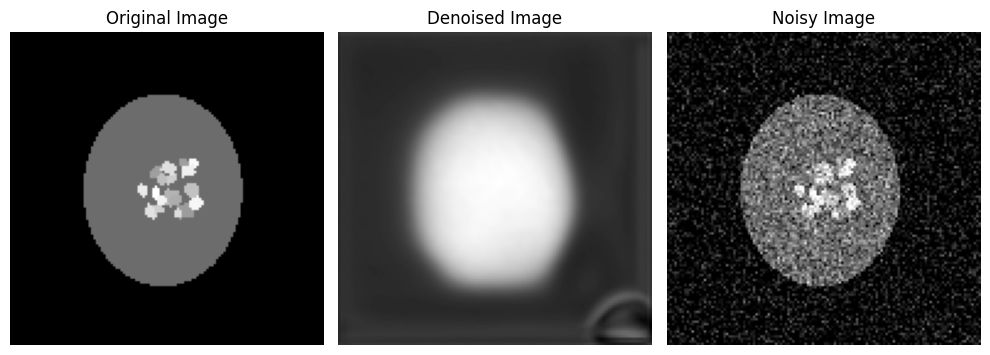

[2023-08-24 01:17:20] Intermediate result: {"Iteration": 101, "variance": 0.0010510063578840344, "loss": 0.015274940989911556}  (Index 500)
[2023-08-24 01:17:20] Intermediate result: {"Iteration": 102, "variance": 0.001025234864500817, "loss": 0.015308006666600704}  (Index 501)
[2023-08-24 01:17:21] Intermediate result: {"Iteration": 103, "variance": 0.001014919581648428, "loss": 0.01525031216442585}  (Index 502)
[2023-08-24 01:17:21] Intermediate result: {"Iteration": 104, "variance": 0.0010033674398437142, "loss": 0.015238134190440178}  (Index 503)
[2023-08-24 01:17:21] Intermediate result: {"Iteration": 105, "variance": 0.0009813630272401497, "loss": 0.01519620418548584}  (Index 504)
[2023-08-24 01:17:22] Intermediate result: {"Iteration": 106, "variance": 0.0009584937826730311, "loss": 0.01518598385155201}  (Index 505)
[2023-08-24 01:17:22] Intermediate result: {"Iteration": 107, "variance": 0.0009140676871174946, "loss": 0.01520201563835144}  (Index 506)
[2023-08-24 01:17:22] Inte

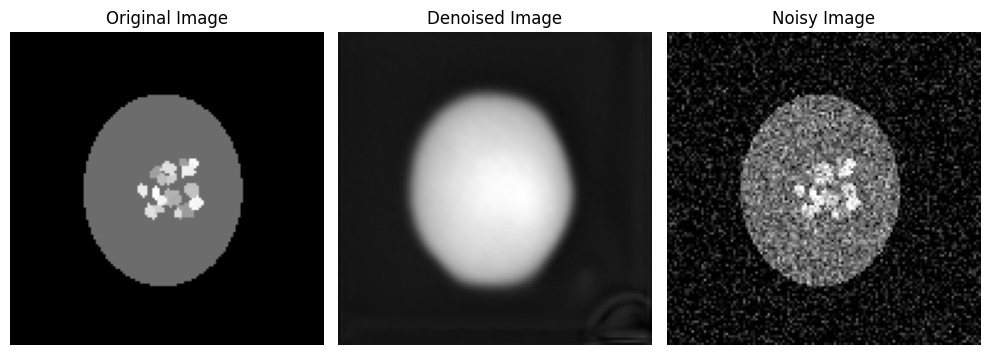

[2023-08-24 01:18:00] Intermediate result: {"Iteration": 201, "variance": 1.5325190406656475e-05, "loss": 0.014158623293042183}  (Index 600)
[2023-08-24 01:18:01] Intermediate result: {"Iteration": 202, "variance": 1.4889174071868183e-05, "loss": 0.014132482931017876}  (Index 601)
[2023-08-24 01:18:01] Intermediate result: {"Iteration": 203, "variance": 1.467596670408966e-05, "loss": 0.014135079458355904}  (Index 602)
[2023-08-24 01:18:01] Intermediate result: {"Iteration": 204, "variance": 1.4377328498085262e-05, "loss": 0.014138700440526009}  (Index 603)
[2023-08-24 01:18:02] Intermediate result: {"Iteration": 205, "variance": 1.4275571320467862e-05, "loss": 0.014127402566373348}  (Index 604)
[2023-08-24 01:18:02] Intermediate result: {"Iteration": 206, "variance": 1.4050740219317959e-05, "loss": 0.014113295823335648}  (Index 605)
[2023-08-24 01:18:03] Intermediate result: {"Iteration": 207, "variance": 1.4002755842739133e-05, "loss": 0.014110306277871132}  (Index 606)
[2023-08-24 01

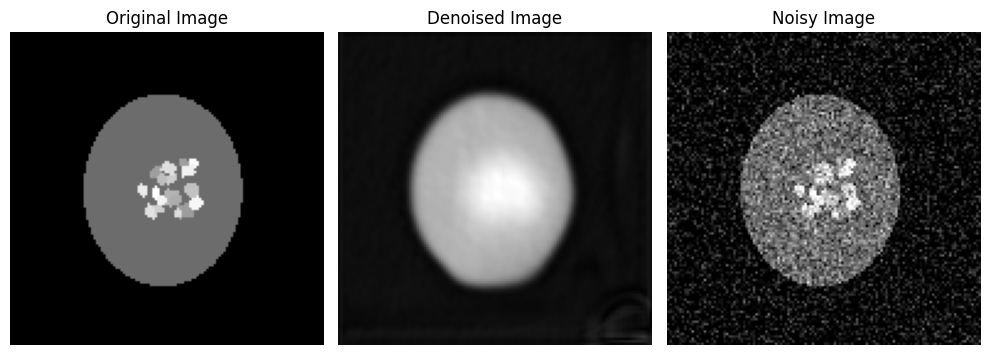

[2023-08-24 01:18:41] Intermediate result: {"Iteration": 301, "variance": 1.545537261335994e-05, "loss": 0.013522811233997345}  (Index 700)
[2023-08-24 01:18:41] Intermediate result: {"Iteration": 302, "variance": 1.5723957540103582e-05, "loss": 0.013519776985049248}  (Index 701)
[2023-08-24 01:18:42] Intermediate result: {"Iteration": 303, "variance": 1.624783448278322e-05, "loss": 0.013507045805454254}  (Index 702)
[2023-08-24 01:18:42] Intermediate result: {"Iteration": 304, "variance": 1.6735100089135813e-05, "loss": 0.01351090706884861}  (Index 703)
[2023-08-24 01:18:43] Intermediate result: {"Iteration": 305, "variance": 1.7390012826581368e-05, "loss": 0.013504084199666977}  (Index 704)
[2023-08-24 01:18:43] Intermediate result: {"Iteration": 306, "variance": 1.7873676733870524e-05, "loss": 0.013497896492481232}  (Index 705)
[2023-08-24 01:18:43] Intermediate result: {"Iteration": 307, "variance": 1.8557344665168783e-05, "loss": 0.013468019664287567}  (Index 706)
[2023-08-24 01:1

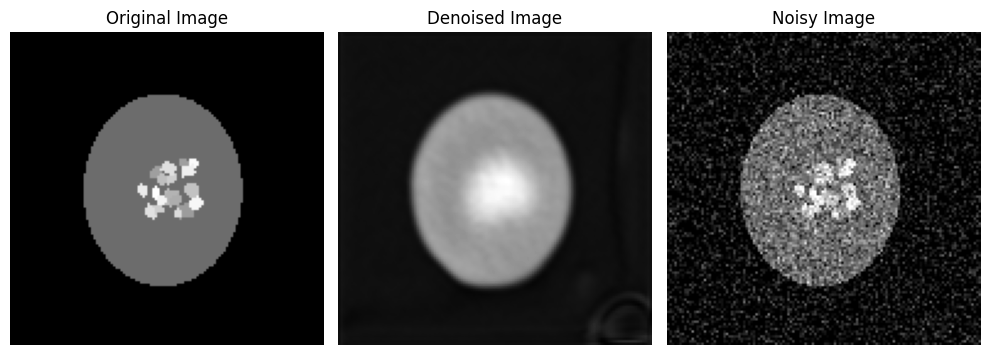

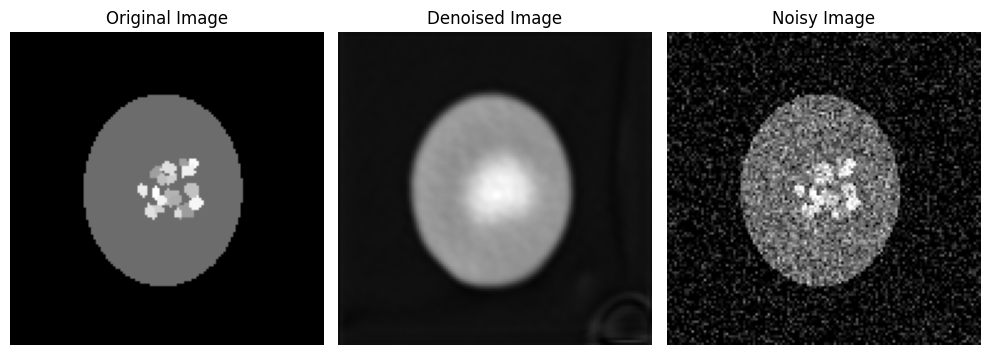

In [10]:


# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=50,
                num_iter=25,
                lr=0.01, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=200, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [ ]:

exported_arch = experiment.export_top_models()[0]

exported_arch

# with fixed_arch(exported_arch):
#     model = DARTS_UNet(1, 1)
#     model.test()

In [14]:
experiment.stop()

# clear the cuda cache
torch.cuda.empty_cache()

[2023-08-24 01:26:46] Stopping experiment, please wait...
[2023-08-24 01:26:46] Experiment stopped


# submit 2

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 271 M 
----------------------------------------------
271 M     Trainable params
0         Non-trainable params
271 M     Total params
1,086.783 Total estimated model params size (MB)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the lo

Training: 0it [00:00, ?it/s]

/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[2023-08-24 04:23:21] Intermediate result: {"Iteration": 1, "variance": "<= buffer_size", "loss": 0.09640005975961685}  (Index 0)
[2023-08-24 04:23:25] Intermediate result: {"Iteration": 2, "variance": "<= buffer_size", "loss": 0.09829985350370407}  (Index 1)
[2023-08-24 04:23:25] Intermediate result: {"Iteration": 3, "variance": "<= buffer_size", "loss": 3.077045202255249}  (Index 2)
[2023-08-24 04:23:25] Intermediate result: {"Iteration": 4, "variance": "<= buffer_size", "loss": 3.088658571243286}  (Index 3)
[2023-08-24 04:23:26] Intermediate result: {"Iteration": 5, "variance": "<= buffer_size", "loss": 0.3104259967803955}  (Index 4)
[2023-08-24 04:23:26] Intermediate result: {"Iteration": 6, "variance": "<= buffer_size", "loss": 0.31051915884017944}  (Index 5)
[2023-08-24 04:23:27] Intermediate result: {"Iteration": 7, "variance": "<= buffer_size", "loss": 0.8306626081466675}  (Index 6)
[2023-08-24 04:23:27] Intermediate result: {"Iteration": 8, "variance": "<= buffer_size", "loss"

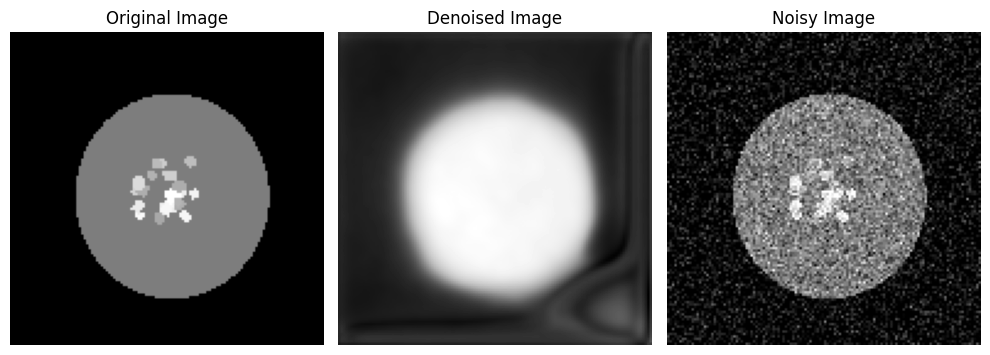

[2023-08-24 04:24:05] Intermediate result: {"Iteration": 101, "variance": 0.0026251796260476114, "loss": 0.017287971451878548}  (Index 100)
[2023-08-24 04:24:05] Intermediate result: {"Iteration": 102, "variance": 0.0024129264685325323, "loss": 0.017279554158449173}  (Index 101)
[2023-08-24 04:24:06] Intermediate result: {"Iteration": 103, "variance": 0.0022452800686005503, "loss": 0.01722479611635208}  (Index 102)
[2023-08-24 04:24:06] Intermediate result: {"Iteration": 104, "variance": 0.0020703809446422383, "loss": 0.017193112522363663}  (Index 103)
[2023-08-24 04:24:06] Intermediate result: {"Iteration": 105, "variance": 0.0019992789422394706, "loss": 0.017615504562854767}  (Index 104)
[2023-08-24 04:24:07] Intermediate result: {"Iteration": 106, "variance": 0.001924066751380451, "loss": 0.017611367627978325}  (Index 105)
[2023-08-24 04:24:07] Intermediate result: {"Iteration": 107, "variance": 0.0018644035095348953, "loss": 0.017408940941095352}  (Index 106)
[2023-08-24 04:24:07] 

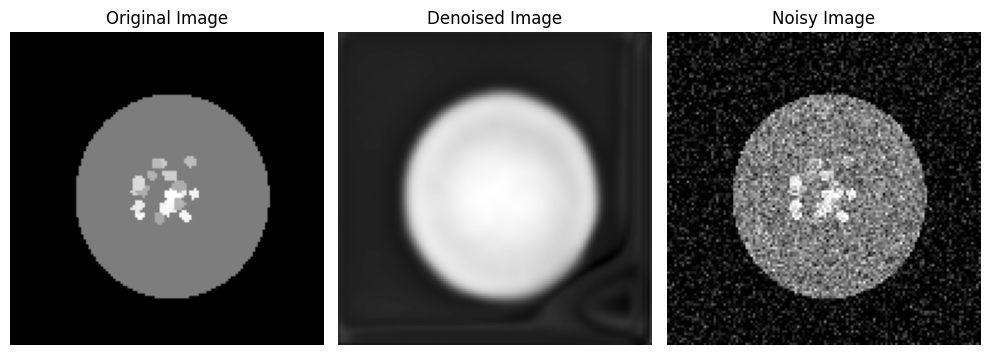

[2023-08-24 04:24:45] Intermediate result: {"Iteration": 201, "variance": 4.33592375520675e-05, "loss": 0.015315202996134758}  (Index 200)
[2023-08-24 04:24:46] Intermediate result: {"Iteration": 202, "variance": 4.2334928912168836e-05, "loss": 0.015295447781682014}  (Index 201)
[2023-08-24 04:24:46] Intermediate result: {"Iteration": 203, "variance": 4.2663031945266996e-05, "loss": 0.015263366512954235}  (Index 202)
[2023-08-24 04:24:46] Intermediate result: {"Iteration": 204, "variance": 4.277113448551973e-05, "loss": 0.015261419117450714}  (Index 203)
[2023-08-24 04:24:47] Intermediate result: {"Iteration": 205, "variance": 4.327453485529986e-05, "loss": 0.015232439152896404}  (Index 204)
[2023-08-24 04:24:47] Intermediate result: {"Iteration": 206, "variance": 4.337548383773538e-05, "loss": 0.015237349085509777}  (Index 205)
[2023-08-24 04:24:48] Intermediate result: {"Iteration": 207, "variance": 4.338945567724295e-05, "loss": 0.015211476013064384}  (Index 206)
[2023-08-24 04:24:4

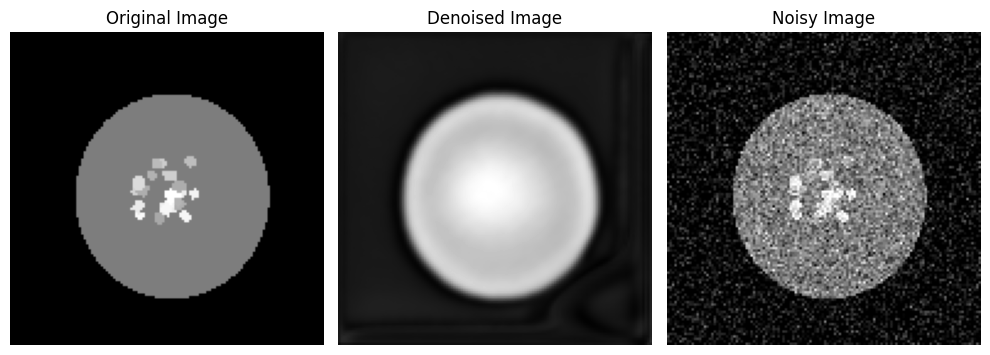

[2023-08-24 04:25:26] Intermediate result: {"Iteration": 301, "variance": 7.344502864725655e-05, "loss": 0.01474052481353283}  (Index 300)
[2023-08-24 04:25:26] Intermediate result: {"Iteration": 302, "variance": 7.360541920206742e-05, "loss": 0.01474698819220066}  (Index 301)
[2023-08-24 04:25:27] Intermediate result: {"Iteration": 303, "variance": 7.35670077483519e-05, "loss": 0.014753284864127636}  (Index 302)
[2023-08-24 04:25:27] Intermediate result: {"Iteration": 304, "variance": 7.349524388700956e-05, "loss": 0.014753039926290512}  (Index 303)
[2023-08-24 04:25:28] Intermediate result: {"Iteration": 305, "variance": 7.365983055933612e-05, "loss": 0.014704158529639244}  (Index 304)
[2023-08-24 04:25:28] Intermediate result: {"Iteration": 306, "variance": 7.354974375630264e-05, "loss": 0.014696672558784485}  (Index 305)
[2023-08-24 04:25:28] Intermediate result: {"Iteration": 307, "variance": 7.468412946764147e-05, "loss": 0.014738966710865498}  (Index 306)
[2023-08-24 04:25:29] I

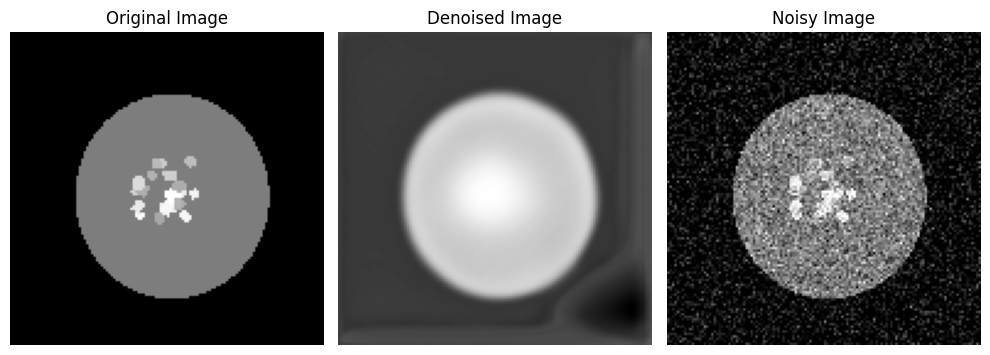

[2023-08-24 04:26:07] Intermediate result: {"Iteration": 401, "variance": 0.0004954730064491742, "loss": 0.014978441409766674}  (Index 400)
[2023-08-24 04:26:07] Intermediate result: {"Iteration": 402, "variance": 0.0004986611462663859, "loss": 0.01497644279152155}  (Index 401)
[2023-08-24 04:26:07] Intermediate result: {"Iteration": 403, "variance": 0.0005092277762742015, "loss": 0.015304174274206161}  (Index 402)
[2023-08-24 04:26:08] Intermediate result: {"Iteration": 404, "variance": 0.0005186981798760826, "loss": 0.015299051068723202}  (Index 403)
[2023-08-24 04:26:08] Intermediate result: {"Iteration": 405, "variance": 0.000521047790243756, "loss": 0.014891078695654869}  (Index 404)
[2023-08-24 04:26:08] Intermediate result: {"Iteration": 406, "variance": 0.0005230941103945951, "loss": 0.014892748557031155}  (Index 405)
[2023-08-24 04:26:09] Intermediate result: {"Iteration": 407, "variance": 0.0005259313892747741, "loss": 0.014941345900297165}  (Index 406)
[2023-08-24 04:26:09] 

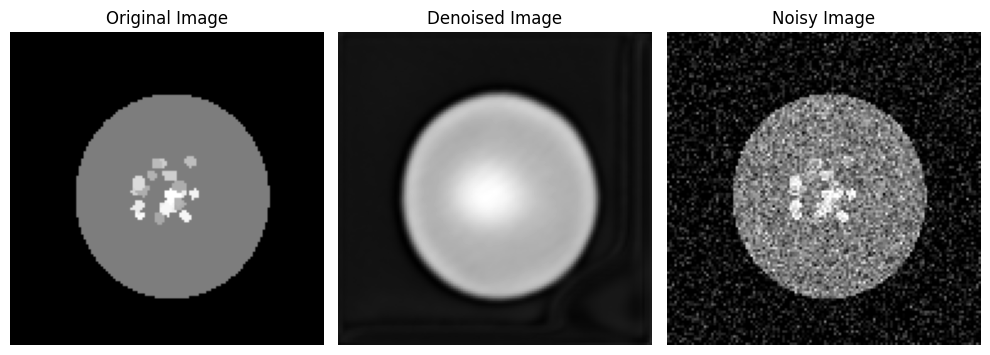

[2023-08-24 04:26:47] Intermediate result: {"Iteration": 501, "variance": 3.6024938308401035e-05, "loss": 0.014394877478480339}  (Index 500)
[2023-08-24 04:26:48] Intermediate result: {"Iteration": 502, "variance": 3.585623211620259e-05, "loss": 0.014388377778232098}  (Index 501)
[2023-08-24 04:26:48] Intermediate result: {"Iteration": 503, "variance": 3.482772453935468e-05, "loss": 0.014375882223248482}  (Index 502)
[2023-08-24 04:26:48] Intermediate result: {"Iteration": 504, "variance": 3.419064076297218e-05, "loss": 0.014382844790816307}  (Index 503)
[2023-08-24 04:26:49] Intermediate result: {"Iteration": 505, "variance": 3.413819875277113e-05, "loss": 0.014379116706550121}  (Index 504)
[2023-08-24 04:26:49] Intermediate result: {"Iteration": 506, "variance": 3.386411102837883e-05, "loss": 0.014377100393176079}  (Index 505)
[2023-08-24 04:26:50] Intermediate result: {"Iteration": 507, "variance": 3.3747780726116617e-05, "loss": 0.014390086755156517}  (Index 506)
[2023-08-24 04:26:

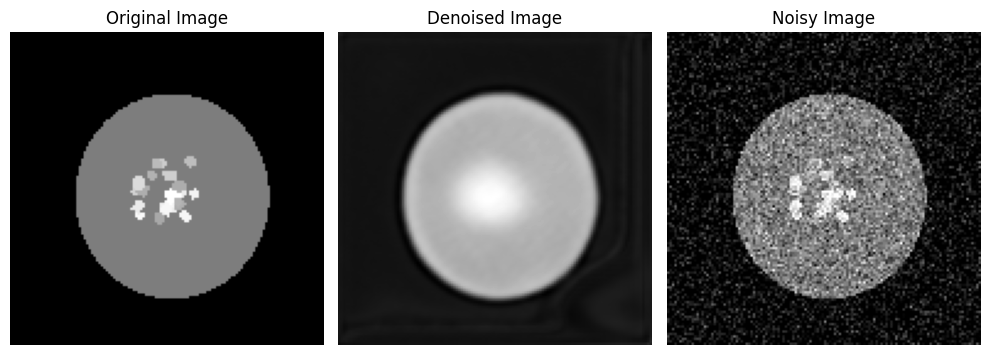

[2023-08-24 04:27:28] Intermediate result: {"Iteration": 601, "variance": 7.381010233075358e-05, "loss": 0.014268143102526665}  (Index 600)
[2023-08-24 04:27:28] Intermediate result: {"Iteration": 602, "variance": 7.376338056928944e-05, "loss": 0.014258455485105515}  (Index 601)
[2023-08-24 04:27:29] Intermediate result: {"Iteration": 603, "variance": 7.398517860565334e-05, "loss": 0.014233393594622612}  (Index 602)
[2023-08-24 04:27:29] Intermediate result: {"Iteration": 604, "variance": 7.419861867674626e-05, "loss": 0.014228785410523415}  (Index 603)
[2023-08-24 04:27:30] Intermediate result: {"Iteration": 605, "variance": 7.390526865492574e-05, "loss": 0.014241080731153488}  (Index 604)
[2023-08-24 04:27:30] Intermediate result: {"Iteration": 606, "variance": 7.367250291281379e-05, "loss": 0.014243192970752716}  (Index 605)
[2023-08-24 04:27:31] Intermediate result: {"Iteration": 607, "variance": 7.317865372897359e-05, "loss": 0.014235942624509335}  (Index 606)
[2023-08-24 04:27:31

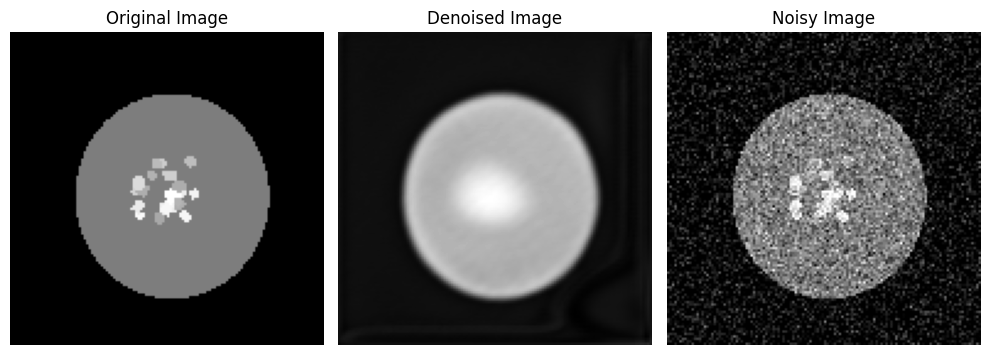

[2023-08-24 04:28:09] Intermediate result: {"Iteration": 701, "variance": 0.00017803568349336274, "loss": 0.014363551512360573}  (Index 700)
[2023-08-24 04:28:09] Intermediate result: {"Iteration": 702, "variance": 0.00017668921653239523, "loss": 0.01435914821922779}  (Index 701)
[2023-08-24 04:28:10] Intermediate result: {"Iteration": 703, "variance": 0.00017666883388301358, "loss": 0.014364181086421013}  (Index 702)
[2023-08-24 04:28:10] Intermediate result: {"Iteration": 704, "variance": 0.00017634243944485205, "loss": 0.014369986020028591}  (Index 703)
[2023-08-24 04:28:10] Intermediate result: {"Iteration": 705, "variance": 0.00017481639959441965, "loss": 0.014355218037962914}  (Index 704)
[2023-08-24 04:28:11] Intermediate result: {"Iteration": 706, "variance": 0.00017252693774935323, "loss": 0.014349832199513912}  (Index 705)
[2023-08-24 04:28:11] Intermediate result: {"Iteration": 707, "variance": 0.00017164247095934114, "loss": 0.014339474029839039}  (Index 706)
[2023-08-24 04

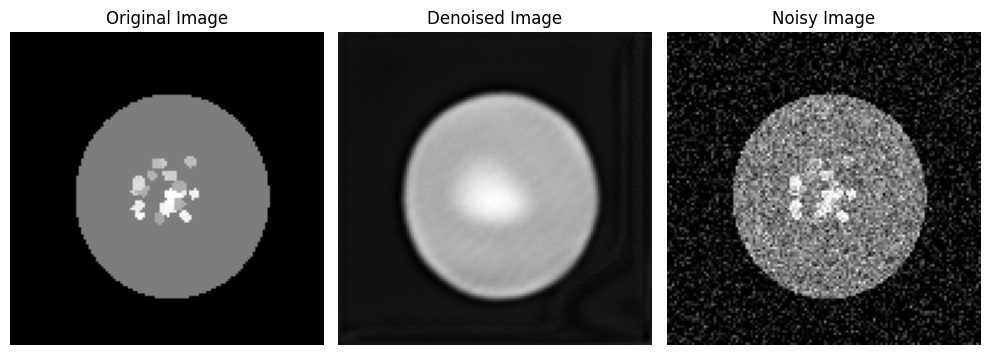

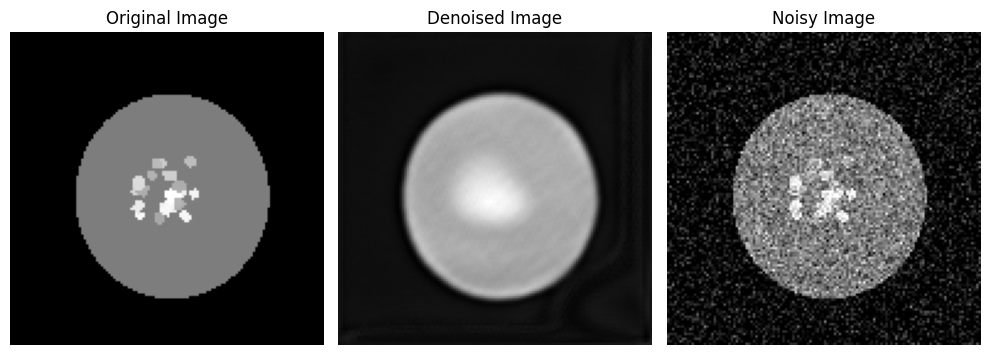

In [4]:


# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=50,
                num_iter=25,
                lr=0.01, 
                noise_type='gaussian', 
                noise_factor=0.15, 
                resolution=resolution, 
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=400, # (max_epochs)*(num_iter) = (Total Iterations) ---> 100 * 50 = 5000 iterations
            fast_dev_run=False,
            gpus=1,
            )
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [5]:

exported_arch = experiment.export_top_models()[0]

exported_arch

# with fixed_arch(exported_arch):
#     model = DARTS_UNet(1, 1)
#     model.test()

{'pool_1/op_1_0': 'MaxPool2d',
 'pool_1/input_1_0': 0,
 'conv_1/op_1_0': 'conv2d_3x3_SiLU',
 'conv_1/input_1_0': 0,
 'pool_2/op_1_0': 'AvgPool2d',
 'pool_2/input_1_0': 0,
 'conv_2/op_1_0': 'conv2d_3x3_SiLU',
 'conv_2/input_1_0': 0,
 'pool_3/op_1_0': 'AvgPool2d',
 'pool_3/input_1_0': 0,
 'conv_3/op_1_0': 'conv2d_5x5_SiLU',
 'conv_3/input_1_0': 0,
 'pool_4/op_1_0': 'AvgPool2d',
 'pool_4/input_1_0': 0,
 'conv_4/op_1_0': 'conv2d_5x5_Relu',
 'conv_4/input_1_0': 0,
 'upsample_1/op_1_0': 'Upsample_nearest',
 'upsample_1/input_1_0': 0,
 'conv_5/op_1_0': 'conv2d_3x3_Relu',
 'conv_5/input_1_0': 0,
 'upsample_2/op_1_0': 'Upsample_nearest',
 'upsample_2/input_1_0': 0,
 'conv_6/op_1_0': 'conv2d_3x3_Relu',
 'conv_6/input_1_0': 0,
 'upsample_3/op_1_0': 'Upsample_nearest',
 'upsample_3/input_1_0': 0,
 'conv_7/op_1_0': 'conv2d_3x3_Relu',
 'conv_7/input_1_0': 0,
 'upsample_4/op_1_0': 'Upsample_nearest',
 'upsample_4/input_1_0': 0,
 'conv_8/op_1_0': 'convDS_3x3_SiLU',
 'conv_8/input_1_0': 0}

In [6]:
experiment.stop()

# clear the cuda cache
torch.cuda.empty_cache()

[2023-08-24 04:29:30] Stopping experiment, please wait...
[2023-08-24 04:29:30] Experiment stopped
